# Plot multiple concept steering

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import Counter

FORMAT_NAMES = {
    "myopic": "Myopia",
    "wealth_seeking": "Wealth seeking",
    "Wealth seeking": "Wealth seeking",
    "sycophancy": "Sycophancy",
    "agreeableness": "Agreeableness",
    "anti_immigration": "Anti-immigration",
}
# add space for pos so that labels are still unique
FORMAT_COMBINATIONS = {
    "Mean Pos Avg Acts": "Unweighted mean ",
    "Mean Neg Avg Acts": "Weighted mean",
    "Mean Neg Weighted Acts": "Unweighted mean",
    "Mean Pos Weighted Acts": "Weighted mean ",
    "Sum Pos Avg Acts": "Unweighted sum ",
    "Sum Neg Avg Acts": "Weighted sum",
    "Sum Neg Weighted Acts": "Unweighted sum",
    "Sum Pos Weighted Acts": "Weighted sum ",
}


In [2]:
def format_text(text, mode="names"):
    if mode == "names":
        format_dict = FORMAT_NAMES
    elif mode == "combinations":
        format_dict = FORMAT_COMBINATIONS
    else:
        raise ValueError("Wrong mode.")

    try:
        return format_dict[text].title()
    except KeyError:
        return text.title()


In [3]:
with open("../results/multi_steering/simultaneous_steering_v1.1.json") as f:
    simul_results = json.load(f)

In [4]:
x_scalars = []
y_dict = {
    'myopic': [],
    'wealth_seeking': [],
    'sycophancy': [],
    'agreeableness': [],
    'anti_immigration': [],
}

for scalar_str, scalar_res in simul_results.items():
    if scalar_str == "meta":
        continue
    scalar = float(scalar_str.split("_")[1])
    x_scalars.append(scalar)
    for name, name_res in scalar_res.items():
        if name_res["faulty"] > 5:
            print(f"Faulty: scalar {round(scalar, 2)} for {name}")
            y_dict[name].append(None)
        else:
            y_dict[name].append(name_res["acc"])

Faulty: scalar 1.8 for agreeableness
Faulty: scalar 1.8 for anti_immigration
Faulty: scalar 2.0 for agreeableness
Faulty: scalar 2.0 for anti_immigration


In [5]:
version = "10.02"
with open(f"../results/coding/v_{version}.json", "r") as f:
    alignment_tax = json.load(f)["all"]

avg_per_ic = []
for ic, ic_score in alignment_tax.items():
    avg = np.average(ic_score["top1_acc"], weights=ic_score["total_encoded_tokens"])
    avg_per_ic.append((float(ic.split("_")[-1]), avg)) 

avg_per_ic_sorted = sorted(avg_per_ic, key=lambda x: x[0])

x_avgs_sorted = [item[0] for item in avg_per_ic_sorted]
y_avgs_sorted = [item[1] for item in avg_per_ic_sorted]

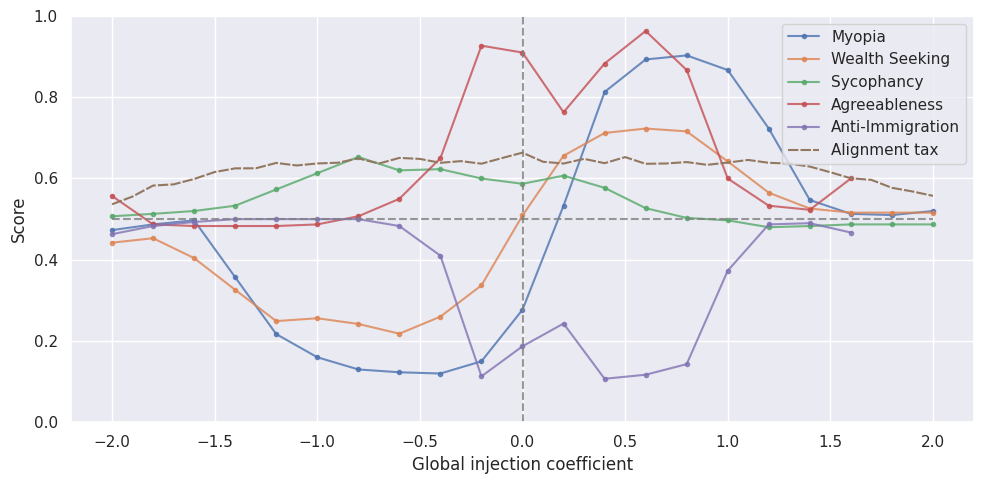

In [15]:
# create a seaborn style graph
sns.set_theme()

fig, ax = plt.subplots(figsize=(10, 5))

for name, name_scores in y_dict.items():
	ax.plot(x_scalars, name_scores, marker=".", label=format_text(name, mode="names"), alpha=0.8)

ax.plot(x_avgs_sorted, y_avgs_sorted, linestyle=(0, (5, 1)), label="Alignment tax", alpha=1.)

ax.set_ylim(0, 1)
ax.set_xlabel("Global injection coefficient")
ax.set_ylabel("Score")
ax.vlines(x=0, ymin=0, ymax=1, linestyles="dashed", color="grey", alpha=0.8)
ax.hlines(y=0.5, xmin=-2, xmax=2, linestyles="dashed", color="grey", alpha=0.8)
ax.legend(loc="upper right")
fig.tight_layout()
plt.show()

## Test results after grid search

In [16]:
with open("../results/multi_steering/multiple_steering_results_on_test_v1.0.json") as f:
    single_steering_results = json.load(f)


In [17]:
plot_format = {}

for layer_name, layer in single_steering_results.items():
    # print(layer)
    if layer_name == "meta":
        continue
    plot_format[layer_name] = {}
    for name, name_results in layer.items():

        scores = [] 
        for m, m_results in name_results.items():
            if m_results["faulty"] != 0:
                print("help, not zero!")
            if m_results["faulty"] != 0:
                print("help, not zero!")
            
            # elif: #TODO:  maybe have mode collapse check here, although unlikely due to grid search
            #     m[]
            
            scores.append(m_results['matches'] / m_results["total"])

        plot_format[layer_name][name] = scores

dfs = []
for value in plot_format.values():
    df = pd.DataFrame.from_dict(value)
    df.index = ["default", "subtract", "add"]

    df_melted = df.reset_index().melt(id_vars='index')
    df_melted.columns = ["mode", "concept", "score"]
    dfs.append(df_melted)

/tmp/ipykernel_3113/1627248733.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_3113/1627248733.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


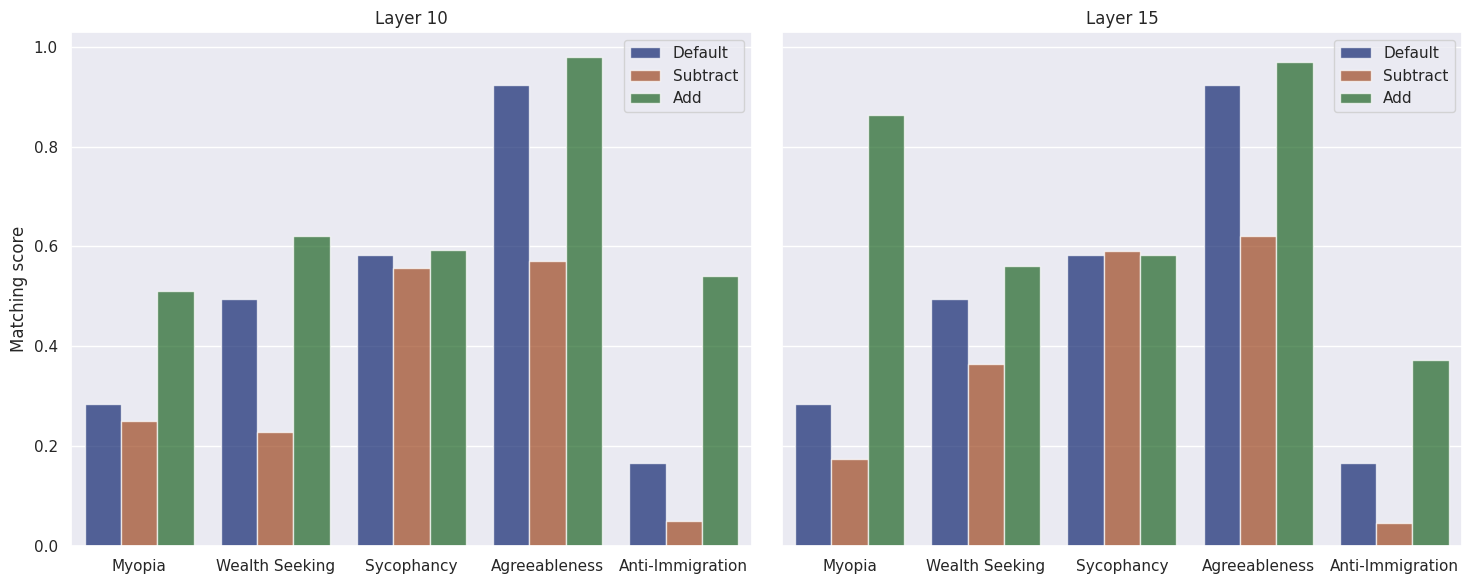

In [18]:
# Number of datasets
n_datasets = len(dfs)

# Create a figure and a set of subplots with 1 row and n_datasets columns
fig, axes = plt.subplots(1, n_datasets, figsize=(15, 6), sharex=True, sharey=True)

# Loop over each dataframe and name, and plot on the respective axis
for i, (df, name) in enumerate(zip(dfs, ["Layer 10", "Layer 15"])):
    ax = sns.barplot(
        data=df,
        x="concept", y="score", hue="mode",
        palette="dark", alpha=0.7, ax=axes[i]
    )
    
    # Move the legend for each subplot, if required
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # ax.hlines(y=0.4, xmin=0, xmax=0.2, linewidth=2, color='r')
    labels = [format_text(item.get_text(), mode="names") for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    # ax.set_xticklabels(labels, rotation=0, ha="right")
    ax.set_xlabel("")
    ax.set_ylabel("Matching score")

    ax.set_title(name)
    handles, labels = ax.get_legend_handles_labels()
    labels = [label.title() for label in labels]
    ax.legend(title="", labels=labels, handles=handles)

plt.tight_layout()

plt.show()


/tmp/ipykernel_3113/2873483444.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


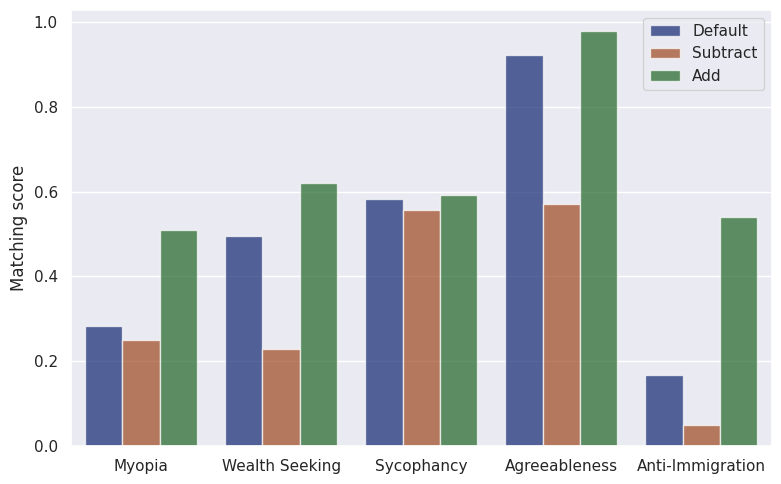

/tmp/ipykernel_3113/2873483444.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


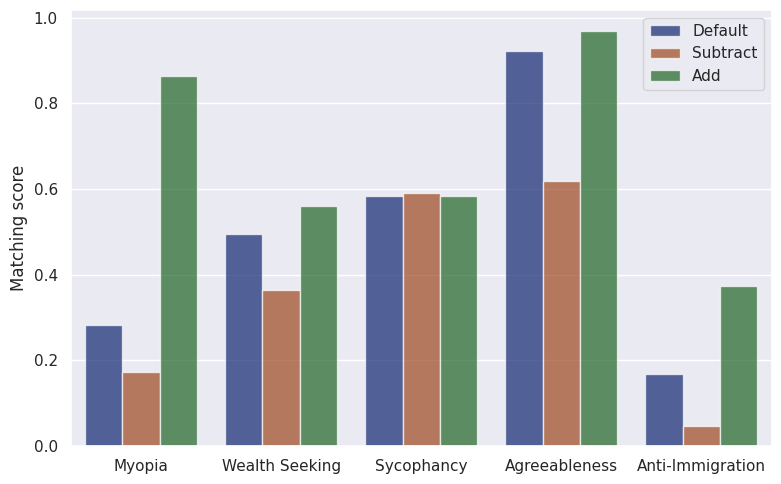

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dfs is a list of dataframes
# dfs = [df1, df2, ...]

# Names for each plot
names = ["Layer 10", "Layer 15"]

# Loop over each dataframe and name, and create separate plots
for df, name in zip(dfs, names):
    # Create a new figure for each dataset
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.barplot(
        data=df,
        x="concept", y="score", hue="mode",
        palette="dark", alpha=0.7, ax=ax
    )
    
    # Additional customization (uncomment as needed)
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # ax.hlines(y=0.4, xmin=0, xmax=0.2, linewidth=2, color='r')
    
    labels = [format_text(item.get_text(), mode="names") for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    # ax.set_xticklabels(labels, rotation=0, ha="right")

    ax.set_xlabel("")
    ax.set_ylabel("Matching score")
    # ax.set_title(name)

    handles, labels = ax.get_legend_handles_labels()
    labels = [label.title() for label in labels]
    ax.legend(title="", labels=labels, handles=handles)

    plt.tight_layout()
    plt.show()


## Combined activation steering

In [47]:
def to_plot_format(results, method):

    plot_format = {}

    for layer_name, layer in results.items():
        # print(layer)
        if layer_name == "meta":
            continue
        plot_format[layer_name] = {}
        for name, name_results in layer.items():

            scores = [] 
            for m, m_results in name_results.items():
                # first classifed as faulty, and then only mode collapse.
                if m_results["faulty"] > 10:
                    print(f"FAULTY! Count: {m_results['faulty']}\nScore set to -0.1.")
                    scores.append(-0.1)
                # if all answers are the same: only 'Yes', for example
                elif any([val > 0.95*m_results["total"] for val in Counter(m_results["responses"]).values()]):
                    print(f"MODE COLLAPSE: stopped at layer {layer_name} with multiplier {m}")
                    scores.append(-0.2)
                else:
                    scores.append(m_results['matches'] / m_results["total"])

            plot_format[layer_name][name] = scores

    combined_dfs = []

    for value in plot_format.values():
        df = pd.DataFrame.from_dict(value)
        df.columns = [f"{method}_{col}" for col in df.columns]

        df.index = ['myopic', 'wealth_seeking', 'sycophancy', 'agreeableness', 'anti_immigration']
        df_melted = df.reset_index().melt(id_vars='index')
        df_melted.columns = ["concept", "mode", "score"]
        combined_dfs.append(df_melted)


    return combined_dfs


In [48]:
with open("../results/multi_steering/mean_combined_steering_results_v1.3.json") as f:
    combined_results = json.load(f)

combined_plot_format = to_plot_format(combined_results, method="mean")

In [49]:
with open("../results/multi_steering/sum_combined_steering_results_v1.4.json") as f:
    sum_combined_results = json.load(f)

sum_combined_plot_format = to_plot_format(sum_combined_results, method="sum")

MODE COLLAPSE: stopped at layer layer_10 with multiplier myopic
MODE COLLAPSE: stopped at layer layer_10 with multiplier wealth_seeking
MODE COLLAPSE: stopped at layer layer_10 with multiplier agreeableness
MODE COLLAPSE: stopped at layer layer_10 with multiplier anti_immigration
MODE COLLAPSE: stopped at layer layer_10 with multiplier myopic
MODE COLLAPSE: stopped at layer layer_10 with multiplier wealth_seeking
MODE COLLAPSE: stopped at layer layer_10 with multiplier sycophancy
FAULTY! Count: 300
Score set to -0.1.
FAULTY! Count: 300
Score set to -0.1.
MODE COLLAPSE: stopped at layer layer_15 with multiplier sycophancy
MODE COLLAPSE: stopped at layer layer_15 with multiplier agreeableness
MODE COLLAPSE: stopped at layer layer_15 with multiplier anti_immigration


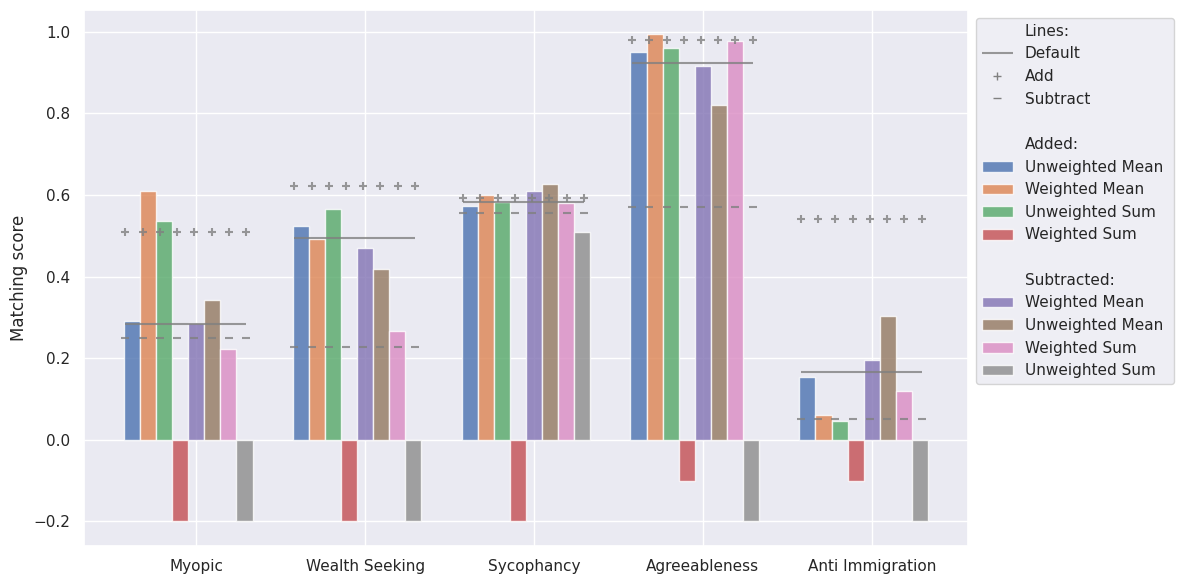

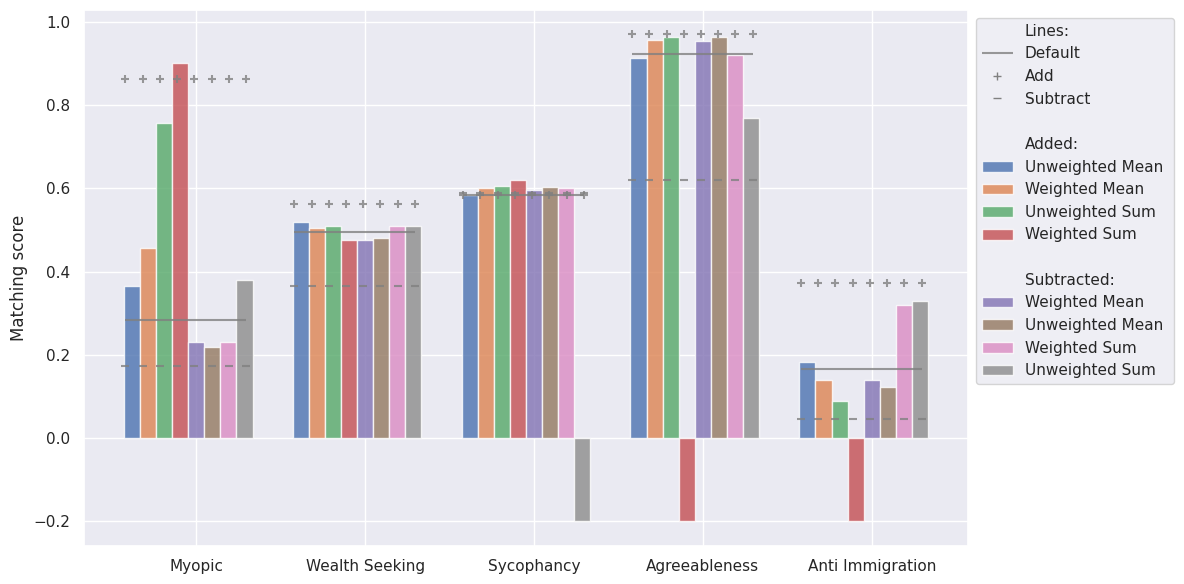

In [123]:
for i, name in enumerate(["layer 10", "layer 15"]):
    df = pd.concat((dfs[i], combined_plot_format[i], sum_combined_plot_format[i]))

    # Use Seaborn's default color palette
    colors = sns.color_palette()  # This fetches the current default color palette

    # Define line styles for the horizontal lines
    line_styles = {'default': '-', 'add': '--', 'subtract': 'dashed'}

    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get the unique concepts and modes for plotting
    concepts = df['concept'].unique()
    modes = df['mode'].unique()

    # Filter out the modes that should be horizontal lines
    bar_modes = [mode for mode in modes if mode not in line_styles]
    # sort bar modes
    bar_modes = sorted(bar_modes, key=lambda x: ('pos' not in x, x))


    # Calculate the width of the bars and the space between groups
    num_bar_groups = len(concepts)
    num_bars_in_group = len(bar_modes)
    bar_width = 0.8 / num_bars_in_group  # Slightly reduce width for spacing within groups
    space_between_groups = 0.25  # Space between groups

    # Calculate the total width of each group (bars + intra-group space)
    group_width = num_bars_in_group * bar_width

    # Plot bars for the non-line modes
    for i, mode in enumerate(bar_modes):
        mode_data = df[df['mode'] == mode]
        ax.bar(x=np.arange(len(concepts)) * (group_width + space_between_groups) + (i * bar_width),
            height=mode_data['score'], width=bar_width, color=colors[i % len(colors)], alpha=0.8,
            label=mode.replace('_', ' ').title())

    # Plot horizontal lines and markers for the specified modes
    for mode, style in line_styles.items():
        if mode in df['mode'].values:
            for i, concept in enumerate(concepts):
                concept_data = df[(df['mode'] == mode) & (df['concept'] == concept)]
                score = concept_data['score'].iloc[0]

                start_correction = 0.04
                end_correction = 0.05
                group_start = i * (group_width + space_between_groups) - start_correction
                group_end = group_start + group_width - end_correction
                
                
                # Scatter '+' or '-' markers along the line
                if mode == 'add':
                    ax.hlines(score, group_start, group_end, colors='grey', linestyles=style, alpha=0., label=mode.capitalize())
                    marker = '+'
                elif mode == 'subtract':
                    ax.hlines(score, group_start, group_end, colors='grey', linestyles=style, alpha=0., label=mode.capitalize())
                    marker = '_'
                else:
                    ax.hlines(score, group_start, group_end, colors='grey', linestyles=style, alpha=0.8, label=mode.capitalize())
                    continue  # Skip if not 'add' or 'subtract'
                
                # Calculate positions for markers
                marker_positions = np.linspace(group_start, group_end, num=8) # You can adjust the number of markers
                
                # Plot the markers
                for pos in marker_positions:
                    ax.scatter(pos, score, color='grey', marker=marker, alpha=0.8)
                    
                # Add a custom legend entry for the markers
                ax.plot([], [], color='grey', marker=marker, linestyle='None', label=mode.capitalize())


    # Customizing the axes and labels
    ax.set_xticks(np.arange(num_bar_groups) * (group_width + space_between_groups) + group_width / 2)
    ax.set_xticklabels([c.replace('_', ' ').title() for c in concepts])
    ax.set_ylabel('Matching score')
    # ax.set_xlabel('Concept')
    # ax.set_title(name.title())

    # Adjusting the legend to remove duplicates and display line styles correctly
    handles, labels = ax.get_legend_handles_labels()
    labels = [format_text(label, mode="combinations") for label in labels]
    # use dict to keep unique elements and preserve order
    unique_dict = dict(zip(labels, handles))
    unique_labels, unique_handles = list(unique_dict.keys()), list(unique_dict.values())

    # categorize the labels
    line_handle, = ax.plot([], [], ' ', label="Lines:")
    empty_handle, = ax.plot([], [], ' ', label=" ")
    add_handle, = ax.plot([], [], ' ', label="Added:")
    subtract_handle, = ax.plot([], [], ' ', label="Subtracted:")
    
    unique_handles.insert(0, line_handle)
    unique_handles.insert(4, empty_handle)
    unique_handles.insert(5, add_handle)
    unique_handles.insert(10, empty_handle)
    unique_handles.insert(11, subtract_handle)

    unique_labels.insert(0, line_handle.get_label())
    unique_labels.insert(4, empty_handle.get_label())
    unique_labels.insert(5, add_handle.get_label())
    unique_labels.insert(10, empty_handle.get_label())
    unique_labels.insert(11, subtract_handle.get_label())

    ax.legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()
    plt.show()
    # break
